# Big Data Analysis final project


## Sentiment Analysis from tweets to detect opnion on LGBT during pride time and in regular time.

### Problem Description

In this project I aimed to investigate whether tweets regarding LGBT during pride month contain a certain sentiment trend when comparing with out of this month. That is, I would like to discover if there is much negative opinion during this time or if the opinion is more positive than in regular times.
I find this question interesting since I have always asked myself if the huge LGBT events might alienate people more than getting them to come closer, although I deeply believe that pride events are crucial to the whole society and to LGBTQ community in particular. 

That research can also show the general tendency in society, which is an interesting question by itself.
Originally my idea was to perform a more coherent investigation only considering a certain county or city. I have started collecting data from pride month in Denver, Colorado. I know that this city has great events for pride, but also, it is less "open" than NY or LA.

The original idea was to crawl tweets from 2019 since after that, covid affected everything and the pride month was not the same as usual. Pride month is celebrated around the globe during June. Also, a big advantage is that it was before Twitter canceled the "place" feature of the tweets. We will try to compare the extracted sentiment from pride month (june) compared to other months of the year. 

I crawled the described tweets from Colorado that contain "lgbt" during pride month, but received very few tweets (even when extending the month to 2 months). Also have crawled tweets from June of all the years 2017 to 2021 and got less data than expected. So I decided to generalize the search. June is typically a pride month all over the world, so I tried to scrape all US and also encountered a relatively small amount of tweets. It is possible that the localization is too hard, at least with the scraper I use.

Eventually I decided to not limit myself, taking into consideration that a large part of the analysis is about looking not only on sentiment analysis, but also statistics on the data. Having the scrape performed without localization limitation results with more than sufficient amount of data. That is, also instead of using data from all the months of June I sample batches of 50,000 tweets from different days in this relevant time period.


### Data Collection Method and Storing 
I scrape tweets using snscrape (https://github.com/JustAnotherArchivist/snscrape), which allows less limited tweets scraping with respect to both activity time intervals and tweets quantity, comparing to the option of scraping tweets with the twitter API. It allows scraping by certain words, specific dates, location (not always helpful as explained). When executing it with both time window and number of maximum tweets, in the case where in this time window there are more than number of tweets, then it will start scraping from last ones (newer) to older and stop when reaching the maximum number. That was the case for my scrapes since I put pretty large time intervals to capture exactly the maximum tweets I define. The specific dates inside the windows of pride month or out of pride month were less important. The important thing was the range of each scrape activity to fall in the month of June or out.

After gathering the data I saved it as .csv files (as precaution) and stored it into the DB. However, for the sake of a clear and coherent notebook I eventually load each of the .csv files, gather them into two dataframes - one for tweets posted in pride month and the other for tweets posted out of prime month. I chose to sample from January, February and March of the same year 2019, to make sure it is not even close to pride month. Further details will be provided along the notebook, close to the relevant part.

To store the data I used a no-SQL Mongo database since I noticed that a lot of the values are Nones, so a relational database would be a waste of space. Also having the data "not complete" (mainly references between users) eliminates the advantages of using a relational db. I have performed several tests to evaluate how many of the users I cover, so for instance observing the "inReplyToUser" in the field "id" compared to the rest of the scraped tweets to see if this user has his own independent tweets. I could not find matches, which leaves me with the conclusion that I better use noSql, to be more flexible and efficient.

### First Analysis - General Statistics
Getting the general overview on the tweets: languages, hashtags etc. Further explanations will be given in the corresponding section of the notebook.

### Second Analysis - Sentiment Analysis
My idea was to go through the list of tweets from June and from other months, filter out the non-English tweets, and analyse each of the tweets to get a sentiment score. The scores range from -1 to 1, while the closer it is to -1, it is a bad opinion, and closer to 1 is positive opinion. To get a general score for each of the two data sets, we need to apply some kind of averaging along each of the datasets. Further details regarding the needed preprocessing and model used are found under the corresponding section of Sentiment Analysis.



In [2]:
import itertools
import snscrape.modules.twitter as sntwitter
import pandas as pd
from datetime import date
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import operator
import time
from math import isnan
from bson.son import SON

The following cell is an example of how I use the SNScrape. In this case we see a search of 50,000 tweets containing 'lgbt' in the time interval between 1/6/2019 and 12/6/2019. Getting to know the posts distribution over time (after performing a lot of tries), I know for sure that this window time will contain more than 50,000, that way I assure to load exactly 50,000 and not less. I could also use only the "until" field and then I also assure I will get exavtly 50,000, however I did not want to accidentally scrape from out of my window of June month, so I left the "since" also on for that part. After every batch I get, I observe the tail (index 49,999) and observe the date it was scraped. Usually it goes between 1 day to 5 days that contain these 50,000 tweets with 'lgbt' in them. 
 
As explained in the beginning of the notebook, it is possible to indicate location and coordinates. Here the query is for locations within 200km around Denver, Colorado. 

In [ ]:
#Example for scraping tweets posted on pride month
df4 = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
    'lgbt near:Denver within:200km since:2019-06-01 until:2019-06-12').get_items(), 50000))

As explained, instead of basing only on the db, I saved the files, so I first load the .csv files for both parts of the data (in June and in other months). 

In [283]:
#loading data from csv files (saved after scraping)
df1 = pd.read_csv('out/pride_world_2019_50000.csv')
df2 = pd.read_csv('out/pride_world_2019_50000_2.csv')
df3 = pd.read_csv('out/pride_world_2019_50000_3.csv')
df4 = pd.read_csv('out/pride_world_2019_50000_4.csv')

frames = [df1, df2, df3, df4]
df_pride = pd.concat(frames)
df_pride.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 49999
Data columns (total 28 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        200000 non-null  int64  
 1   url               200000 non-null  object 
 2   date              200000 non-null  object 
 3   content           200000 non-null  object 
 4   renderedContent   200000 non-null  object 
 5   id                200000 non-null  int64  
 6   user              200000 non-null  object 
 7   replyCount        200000 non-null  int64  
 8   retweetCount      200000 non-null  int64  
 9   likeCount         200000 non-null  int64  
 10  quoteCount        200000 non-null  int64  
 11  conversationId    200000 non-null  int64  
 12  lang              200000 non-null  object 
 13  source            200000 non-null  object 
 14  sourceUrl         200000 non-null  object 
 15  sourceLabel       200000 non-null  object 
 16  outlinks          619

In [284]:
df1 = pd.read_csv('out/no_pride_world_2019_50000_1.csv')
df2 = pd.read_csv('out/no_pride_world_2019_50000_2.csv')
df3 = pd.read_csv('out/no_pride_world_2019_50000_3.csv')
df4 = pd.read_csv('out/no_pride_world_2019_50000_4.csv')

frames = [df1, df2, df3, df4]
df_no_pride = pd.concat(frames)
df_no_pride.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 49999
Data columns (total 28 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        200000 non-null  int64  
 1   url               200000 non-null  object 
 2   date              200000 non-null  object 
 3   content           200000 non-null  object 
 4   renderedContent   200000 non-null  object 
 5   id                200000 non-null  int64  
 6   user              200000 non-null  object 
 7   replyCount        200000 non-null  int64  
 8   retweetCount      200000 non-null  int64  
 9   likeCount         200000 non-null  int64  
 10  quoteCount        200000 non-null  int64  
 11  conversationId    200000 non-null  int64  
 12  lang              200000 non-null  object 
 13  source            200000 non-null  object 
 14  sourceUrl         200000 non-null  object 
 15  sourceLabel       200000 non-null  object 
 16  outlinks          649

Let us look at some entries of the dataframe:

In [5]:
df_pride.head(2)

,Unnamed: 0,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,...,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags
0,0,https://twitter.com/RenanQuinalha/status/11454...,2019-06-30 23:59:59+00:00,"Já já, às 21h05, vai ser exibido na @GloboNews...","Já já, às 21h05, vai ser exibido na @GloboNews...",1145482142031515648,"{'username': 'RenanQuinalha', 'id': 1603253768...",1,1,35,...,NaN,NaN,NaN,NaN,NaN,"[{'username': 'GloboNews', 'id': 142393421, 'd...",NaN,NaN,"['Pride2019', 'LGBTQoftwitter']",NaN
1,1,https://twitter.com/sezginnnerr/status/1145482...,2019-06-30 23:59:59+00:00,"Tecavüz sapıklıktır, çocuklara yeltenmek sapık...","Tecavüz sapıklıktır, çocuklara yeltenmek sapık...",1145482141561757697,"{'username': 'sezginnnerr', 'id': 3240784090, ...",0,0,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['LgbtSapıklıktırAhlaksızlıktır'],NaN


### Discussion regarding columns to keep or change: 
- Observing the different columns, some of them are more interesting and some are less. The are some columns that it is obvious that there is no need to keep them such as: "url", *"source"*, *"sourceUrl"*, *"sourceLabel"*.
- The Field of *"renderedContent"* is expected to be the same as the "content" column so we can also eliminate it. 
- As explained in the beginning of the notebook, the data is not complete in the sense that the relations between users is probably useless because probably the referred user/tweet does not appear in my dataset. That means that many of the fields that contain references can be eliminated before storing it in the DB. However, i would like to save the property of whether the tweet was written as a reply, so it possible to only save the field *"inReplyToTweetId"* and eliminate *"inReplyToUser"*. Just as well, as we don't save that data as relational, there are other fields that can be eliminated: *"id"* and *"conversationId"*, *"mentionedUsers"*. 
- For the purpose of only counting links, we can get rid of *"tcooutlinks"* and use only the "outlinks". 
- *"Cashtags"*, *"retweetedTweet"* can be eliminated. 
 

In light of the goal of having all of the tweets, both from pride time and out of pride time, in the same database, to be able to process them all together but also to query part of them, I add another column called "pride_month". It will be True in case the tweet was posted in pride month and False otherwise.
 
In addition let's observe the variables to adjust types if needed. We can convert Language to be categorical instead of 'object' since there is a limited number of options. 



### Columns and merging data pipeline 
Currently what we have is two data frames: one contains tweets posted during pride month and the other contains tweets posted at other times of the year. At this point I will do the following steps:
1. Add pride_month flag with the True/False accordingly to each of the dataframes. 
2. Merge the two dataframes into one big dataframe. 
3. Define which columns are to be kept (as explained above) and set a new dataframe that contains all the relevant information. 
4. Add a column for index, with unique indices for each tweet.
5. Convert the language column to categorical. 
6. Struct the tweets as dictionary
7. Store the data in mongoDB for further processing and analysis. 


In [285]:
df_pride = df_pride.assign(pride_month=pd.Series(np.ones((1, 200000), dtype=bool)[0]))
df_no_pride = df_no_pride.assign(pride_month=pd.Series(np.zeros((1, 200000), dtype=bool)[0]))

In [286]:
#MERGING
frames = [df_pride, df_no_pride]
df = pd.concat(frames)

In [287]:
#WCOLUMNS FILTERING:
columns_to_keep = ['date', 'content', 'user', 'replyCount', 'retweetCount', 'likeCount',\
                   'quoteCount','lang', 'outlinks', 'media', 'retweetedTweet', 'quotedTweet', 'inReplyToTweetId', \
                    'coordinates', 'place', 'hashtags', 'pride_month']
current_df = df[columns_to_keep]

In [288]:
pd.options.mode.chained_assignment = None 
current_df.insert(0, 'index', range(0, len(current_df)))
current_df['lang'] = current_df['lang'].astype('category')
current_df.info()
tweets_dict = current_df.to_dict(orient='records')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   index             400000 non-null  int64   
 1   date              400000 non-null  object  
 2   content           400000 non-null  object  
 3   user              400000 non-null  object  
 4   replyCount        400000 non-null  int64   
 5   retweetCount      400000 non-null  int64   
 6   likeCount         400000 non-null  int64   
 7   quoteCount        400000 non-null  int64   
 8   lang              400000 non-null  category
 9   outlinks          126860 non-null  object  
 10  media             58575 non-null   object  
 11  retweetedTweet    0 non-null       float64 
 12  quotedTweet       25503 non-null   object  
 13  inReplyToTweetId  149473 non-null  float64 
 14  coordinates       14861 non-null   object  
 15  place             14861 non-null   object  
 16  has

### Loading to mongoDB
After obtaining all the data as dataframe that contains a total of 400,000 tweets, while half of them are from pride month and half from other regular times of the same year, we can now load the data into the mongo database. 

In [3]:
from pymongo import MongoClient
import json
import pymongo

client = MongoClient('localhost', 27017, username='mongoadmin', password='pass1234')

In [4]:
# let's create a new DB - bda
database = client['bda']
collection = database['lgbt_tweets']

In [291]:
collection.insert_many(tweets_dict)

In [5]:
n_tweets = collection.count_documents({})
n_tweets

400000

At this point, we can discard all the irrelevant heavy variables we used before since we work will be done with the database. Those will be all the dataframes.

In [293]:
%reset_selective -f df
%reset_selective -f frames

### Language analysis
Let us visualize the languages in the data set. Since the tweets are scraped in the states, we expect to have most of the tweets in English. 

In [130]:
current_tweets = list(collection.find({}, {'lang':1, 'inReplyToTweetId':1, 'quotedTweet':1,
'retweetedTweet':1, 'hashtags': 1}))

400000

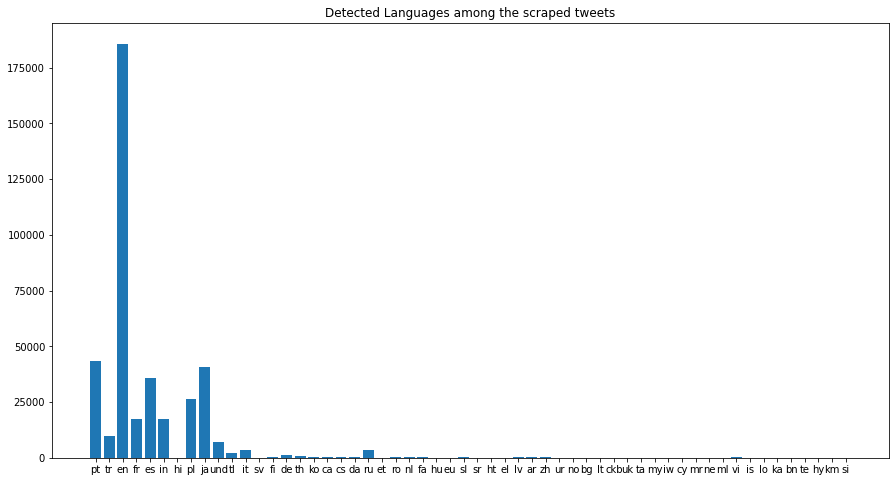

In [131]:
langsList = []
for t in current_tweets:
    langsList.append(t['lang'])
D = Counter(langsList)
fig = plt.figure(1, [15, 8])
plt.bar(range(len(D)), D.values(), align='center')
plt.xticks(range(len(D)), D.keys())
plt.title('Detected Languages among the scraped tweets')
plt.show()


Observing the histogram of langauges we can see that English tweets are by far the most common. Let us calculate which pecent of total tweets are the English ones. 

In [151]:
english_count = sorted(D.values(), reverse=True)[0]
normalized = english_count/sum(D.values())
print('English tweets form ' +str(normalized)+ ' from out total data')

English tweets form 0.4644775 from out total data


Almost 50% of the tweets are in English, as the international language it makes total sense.

### Places analysis
Large part of the data does not contain location, however, over 14k instances do conatain this information. Let us visualize the different countries distribution.

In [36]:
current_tweets = list(collection.find({}, {'place':1}))

---- Total number of countries is: 126


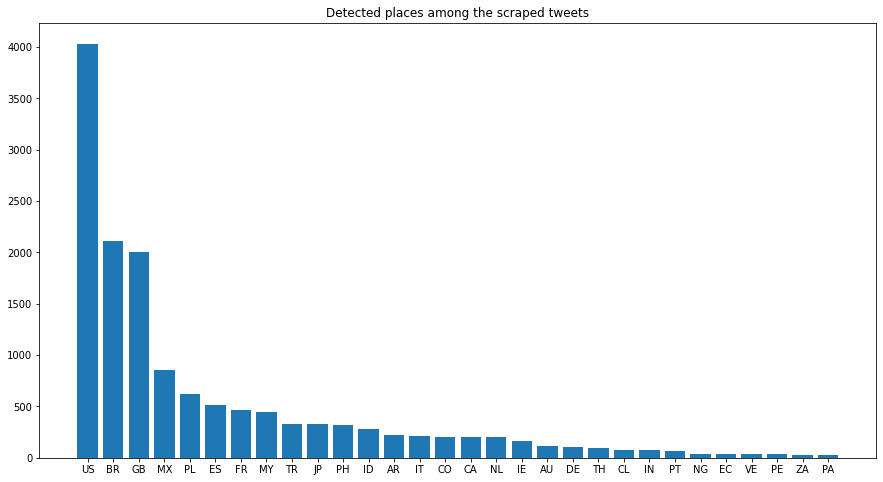

In [80]:
placesList = []
# current_tweets.rewind()
for t in current_tweets:
    if type(t.get('place')) is not float:
        text = t.get('place')
        text_lst = [element.strip('\':,}') for element in text.split()]
        placesList.append(text_lst[-1])
D = Counter(placesList)
print('---- Total number of countries is: ' + str(len(D)))
subset = dict(D.most_common(30))
fig = plt.figure(1, [15, 8])
plt.bar(range(len(subset)), subset.values(), align='center')
plt.xticks(range(len(subset)), subset.keys())
plt.title('Detected places among the scraped tweets')
plt.show()

We can see that most of the tweets come from the states that are more than 50 states together so that makes sense. Then Brazil has the second highest number of tweets. Third by small difference, Great Britain. Another fact that might affect is that the place features do not function for all the world in the same way, which might cause that trend. Another reason could be that twitter is more popular in the states than in the rest of the countries. It looks those highest three together form a huge part of the whole tweets that contain the value of place. That also might explain the huge part of English tweets (US and Great Britain). 

In [79]:
countries_count = sorted(D.values(), reverse=True)
us_count = countries_count[0]
br_count = countries_count[1]
gb_count = countries_count[2]
normalized = (us_count+br_count+gb_count)/sum(D.values())
print('US tweets form ' +str(normalized)+ ' from out total data')

US tweets form 0.547944283695579 from out total data


As suspected, the three highest count countries together form more than 50% of the total amount of tweets with place value. 

### Tweet Types Analysis
Let us look at the type of tweets: *retweets*, *replies*, *quotations* or *original tweets*.  We can know most of the answers observing the info() I have printed in previous steps after creating all of the database. It is possible to see how many non-nulls exist in each of the columns of the data. 
To count the number of each one of the categories, we loop over all the data using the cursor. In each loop iteration we check if *'retweetedTweet'* is not *float* since *nan* has the type of *float*. In case we had some value there it is expected to be boolean. If it is *nan* then the counter of retweets increases with one. A tweet that was detected as a retweet is not "original" in the sense that it was not written from scratch at the time. Then we change the flag of originality to be false in case that other option applies. Similarly I check for values of *quotedTweets* with comparison to *float* type. Here in case that the tweet is quoted, we expect to have some information on the original tweet. For verification if the tweet is a response to someone, I have looked at *"inReplyToTweedId"* that is defined to be *float*. Then we use the function "isnan" to make sure it does not contain a nan value. If all the options were checked and none of the was true, then the flag of originality stays with *True* and then we add one to the original tweets counter.  


In [17]:
retweets = replies = quotations = originals = 0
current_tweets.rewind() #Reset cursor
for t in current_tweets:
    original_flag = True
    if type(t['retweetedTweet']) is not float:
        retweets=retweets+1
        original_flag = False
    if type(t['quotedTweet']) is float:  #nan is captured as float. When it has a value it is expected to be a string. 
        quotations = quotations+1
        original_flag = False
    if isnan(t['inReplyToTweetId']) is not True:
        replies = replies+1
        original_flag = False
    if original_flag:
        originals = originals+1

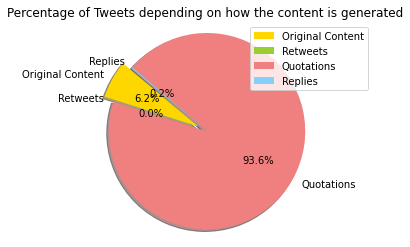

In [18]:
# ----------- Pie Chart ------------------------
labels = 'Original Content', 'Retweets', 'Quotations', 'Replies'
sizes = [originals, retweets, quotations, replies]
frequencies = [x/n_tweets for x in sizes]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0) # explode 1st slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Percentage of Tweets depending on how the content is generated')
plt.legend()
plt.show()


We can see that most of the tweets, more than 90% are quoted tweets. Only around 6% are original tweets. I suspect that having tweeter in many cases kind of political tool, than a lot of tweets from famous or important people are being either quoted or retweeted. Moreover, posts that contain media usually attract more audience (https://sproutsocial.com/insights/types-of-social-media-content/). Clearance: A tweet you share publicly with your followers is a retweet. A quote tweet is a retweet with a comment or media that you have added.


### Hashtags Analysis
The hashtags are scraped as str sequence, and in case there are no hashtags in the tweet then the value is *nan* I recognize the hashtags that are not nan by verifying their type is str. Then to get the actual list of hashtags from each of the tweets, I had to parse this string. the process I do is the following:
1. Getting rid of the chars of "\[", "\]", and (\'). 
2. Using 'split' to get each of the hashtags separated as elements in a list.
3. Again stripping redundant characters. 
4. Lowering all the letters. I did that after observing duplications in the results like "LGBT" and "lgbt". 
5. If the list contains more than one element, I iterate over the list to make sure the hashtag list will be flat. 


In [73]:
def common_hashtags(current_tweets):
    current_tweets.rewind()
    start_time = time.time()
    hash_list = []
    for t in current_tweets:
        if type(t['hashtags']) is str:
            current_hashtags = [element.strip('\'').lower() for element in t.get('hashtags').strip('[\']').split(', ')]
            if len(current_hashtags) > 1:
                for hashtag in current_hashtags:
                    hash_list.append(hashtag)
            else:
                hash_list.append(current_hashtags[0])
    D = Counter(hash_list)
    subset = dict(D.most_common(20))
    sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))
            # ----------- Horizontal Bar Plot ------------------------
    pos = range(len(sorted_subset))
    fig = plt.figure(1, [15, 8])
    plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'yellowgreen')
    plt.yticks(pos, [val[0] for val in sorted_subset])
    plt.tight_layout()
    plt.title('Top 20 of hashtags captured')
    plt.show()
    print('Time elapsed for execution ' + str(time.time()-start_time) + ' seconds')
    return sorted_subset


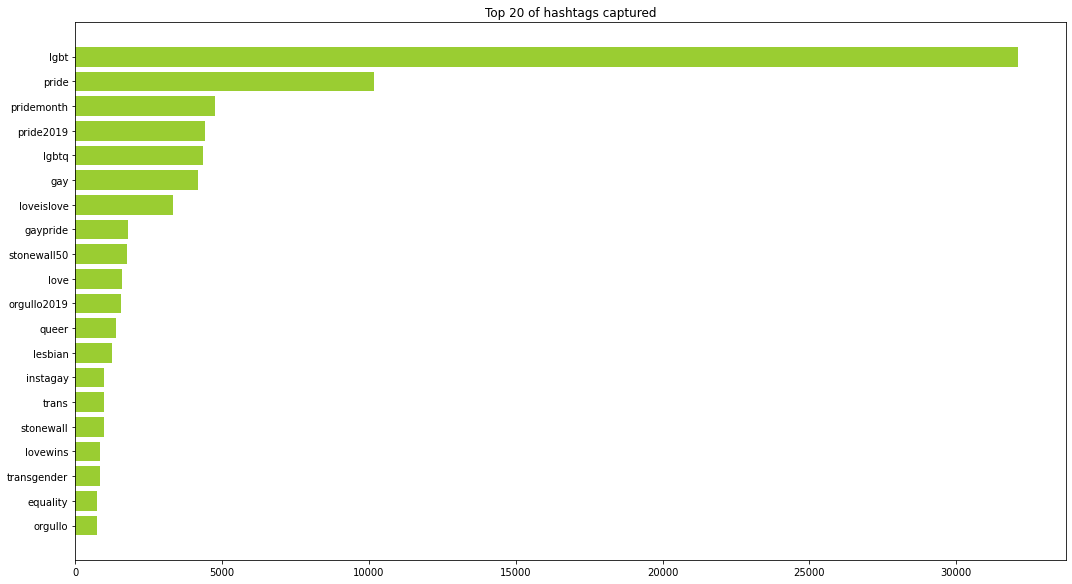

Time elapsed for execution 1.5672495365142822 seconds


In [74]:
pride_tweets = collection.find({'pride_month': True}, {'hashtags':1})
pride_hashtags = common_hashtags(pride_tweets)

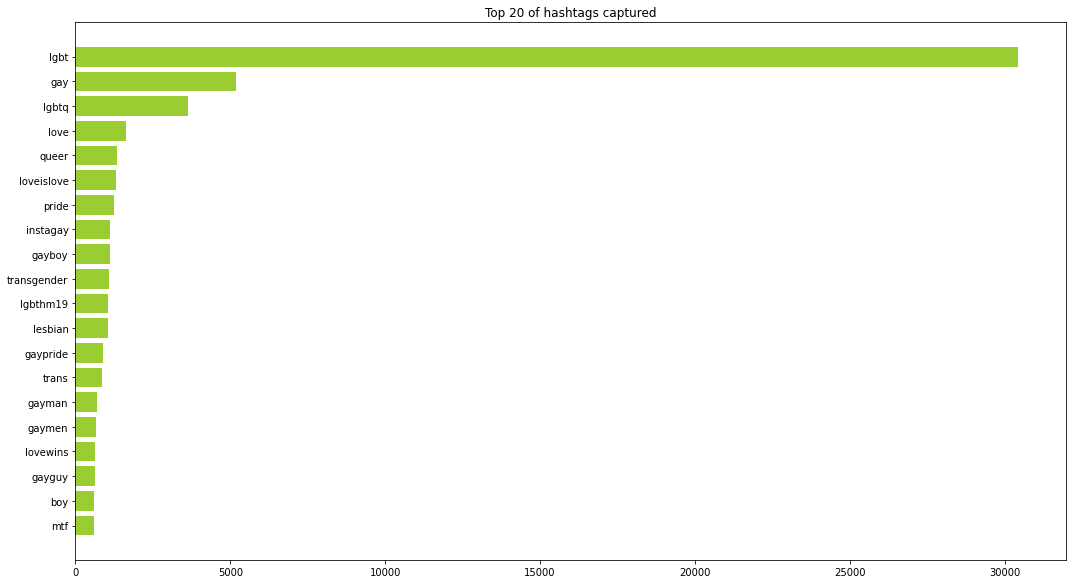

Time elapsed for execution 1.624946117401123 seconds


In [75]:
no_pride_tweets = collection.find({'pride_month': False}, {'hashtags':1})
no_pride_hashtags = common_hashtags(no_pride_tweets)

##### Hashtags instights and thoughts
We can see that the most common by far hashtag in pride month is PRIDEMONTH2019. Most of the hashtags both for pride month and regular time contain words that symbol tolerance and empathy. 
We can see the hashtag of "pride2019" as 4th place most common, which does not appear in the common hashtags from january to March 2019. We see "orgullo2019" and "orgullo" during the pride month, which are the only non-English hashtags among the lists. LoveisLove is steady all in all times as one of most common hashtags. 

### Most popular tweets analysis
We can look at the tweets with highest value for:
1. replyCount 
2. retweetCount       
3. likeCount           
4. quoteCount. 

It is very probable that we will see correlation between those. 

#### Highest Reply Count

In [120]:
pipeline = [
        {'$match': {'pride_month': True}},
        {"$sort": SON([("replyCount", pymongo.DESCENDING)])},
        {'$limit': 1}
    ]

res = collection.aggregate(pipeline)
for sample in res:
    print('content: '+ sample['content'])
    print('replyCount: ' + str(sample['replyCount']))
    print('user: ' + sample['user'])

content: Dear @VP you are a hate mongering, fear based weasel &amp; your biggest irony is that if there was hell, you’d 100% be  going there. I hope you go 2 prison 4 crimes against humanity re: the lgbt community, women’s rights &amp; the babies u rip from the arms of parents seeking our help https://t.co/MDD9p9UuFm
replyCount: 4057
user: {'username': 'SarahKSilverman', 'id': 30364057, 'displayname': 'Sarah Silverman', 'description': "we're on a planet in outer space. (((she/her)))", 'rawDescription': "we're on a planet in outer space. (((she/her)))", 'descriptionUrls': None, 'verified': True, 'created': datetime.datetime(2009, 4, 11, 1, 28, 47, tzinfo=datetime.timezone.utc), 'followersCount': 12281358, 'friendsCount': 1769, 'statusesCount': 19513, 'favouritesCount': 45742, 'listedCount': 50911, 'mediaCount': 1292, 'location': 'state of Palestine ', 'protected': False, 'linkUrl': 'http://Apple.co/sarahsilvermanpodcast', 'linkTcourl': 'https://t.co/li4bxrvdvV', 'profileImageUrl': 'http

This tweet is refering to Vice President of the US during Trump time - Mike Pence. Mike Pense is known for his anty LGBT community. This tweet was in response to the following tweet:
<div>
<img src="vpMike.png" width="300"/>
</div>

We can also see that this is a tweet by Sarah Silverman, very famous comedian and actress in the US. Of course that it is to be expected to get these numbers of exposure from famous people only. 

#### Highest Retweet Count

In [113]:
pipeline = [
        {'$match': {'pride_month': True}},
        {"$sort": SON([("retweetCount", pymongo.DESCENDING)])},
        {'$limit': 1}
    ]

res = collection.aggregate(pipeline)
for sample in res:
    print('content: '+ sample['content'])
    print('replyCount: ' + str(sample['replyCount']))

content: 50 years ago, history was written at the Stonewall Inn when New York's LGBT community stood up, spoke out, and started a movement. In 2016 I was proud to designate it as a national monument—a reminder the arc of our history is an arc of progress as long as we keep pushing for it. https://t.co/xyvYfuoJwK
replyCount: 3803


Those words look familiar, and as if it was someone very important. let us look at who is the publisher. 

In [112]:
res = collection.aggregate(pipeline)
for sample in res:
    print('user: '+ sample['user'])

user: {'username': 'BarackObama', 'id': 813286, 'displayname': 'Barack Obama', 'description': 'Dad, husband, President, citizen.', 'rawDescription': 'Dad, husband, President, citizen.', 'descriptionUrls': None, 'verified': True, 'created': datetime.datetime(2007, 3, 5, 22, 8, 25, tzinfo=datetime.timezone.utc), 'followersCount': 130432065, 'friendsCount': 587562, 'statusesCount': 16328, 'favouritesCount': 0, 'listedCount': 222227, 'mediaCount': 2359, 'location': 'Washington, DC', 'protected': False, 'linkUrl': 'http://obamabook.com', 'linkTcourl': 'https://t.co/FPuJ0CENpo', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/1329647526807543809/2SGvnHYV_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/813286/1633800288', 'label': None}


We can see that this is no other than *Barack Obama*, former president of the US. Obama is very pro-lgbt, and here he speaks about Stonewall where the most progressive manifest up until those days took place, which was triggered by a police raid. That is a very important place and every guided tour in NY in the *Greenwich Village, Manhattan* will tell the story. These days in NY pride, there are activities that were called after Stonewall.

#### Highest like count

In [161]:
pipeline = [
        {'$match': {'pride_month': True}},
        {"$sort": SON([("likeCount", pymongo.DESCENDING)])},
        {'$limit': 1}
    ]

res = collection.aggregate(pipeline)
for sample in res:
    print('content: '+ sample['content'])
    print('likeCount: ' + str(sample['likeCount']))

content: 50 years ago, history was written at the Stonewall Inn when New York's LGBT community stood up, spoke out, and started a movement. In 2016 I was proud to designate it as a national monument—a reminder the arc of our history is an arc of progress as long as we keep pushing for it. https://t.co/xyvYfuoJwK
likeCount: 172413


The tweet with highest like counts is the same one as the highest retweet count, the one of Obama. Not very surprising that we detect some correlations between those, that check different channels of popularity.  

#### Highest Quote count

In [162]:
pipeline = [
        {'$match': {'pride_month': True}},
        {"$sort": SON([("quoteCount", pymongo.DESCENDING)])},
        {'$limit': 1}
    ]

res = collection.aggregate(pipeline)
for sample in res:
    print('content: '+ sample['content'])
    print('quoteCount: ' + str(sample['quoteCount']))

content: “Kahit anong gawin mo lalaki ka pa din”

She wanted to offer flowers as peace offerings but ended up being insulted. If that’s the message that “God” has for the LGBT community, y’all can keep it.  

Props to ya bb, @gigiesguerra ❤️ 
#ResistTogether #PRIDE2019 https://t.co/mclPT4cwse
quoteCount: 6242


This tweet contained a video where a girl that appears to be from the community, offers flowers to people while protesting agains lgbt. The post is defending lgbt, and apparently got a huge amount of attention. 

## Sentiment analyzer

#### General Description of the task
Now that we got familiar with the data, we can dive in more, into the content work. My purpose was to scrape tweets in the month of pride in a city, compared to tweets from regular times, and to see if there exists a tendency for more negativity or more positivity in the pride times. 


#### Sentiment Analyzer model
I chose to apply the sentiment analyzer with a distilled version of BERT that is called 'roberta'. What is special about this specific analyzer is that it was trained on English **tweets** for sentiment analysis purposes. That is, the language it was trained on is the natural language, and there is no point in lemmatizing the words or performing a lot of preprocessing methods we know. (https://github.com/cardiffnlp/tweeteval).
This analyzer can be found in the 'transformers' package of python that is developed by "Hugging Faces"  community (https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment). Roberta is able to exploit things like emojis and hashtags for sentiment analysis, which can be very helpful for our goal. 
 
Roberta sentiment analyzer result for each input is a list of 3 probabilities that sum to 1. Those are the probability that the input is positive opinion, then neutral opinion and lastly negative opinion. To simplify the results I will take the positive probability and rescale it to the range [-1,1], such that, if it is closer to 1, the input is very likely positive. In the opposite case, when close to -1 it is probably more negative than positive. The idea is to apply the model on every tweet of the two datasets (pride month and not pride month), and finally compute the average of the scores. 
 
This analysis is not complete since the neutral case is not taken into consideration. However, after some testing I have done with this model, usually it has a big tendency to either the positive or the negative interpretation, and less of intermediate values that are close  to 0.  


#### Data Preprocessing
There are some steps that can be taken when processing natural language, and of course that the preprocessing steps are a lot dependent on the data and the model - adjust the data to be represented in the way the model is expecting. The good thing with our model here is that it was trained on tweets. The effect of that is explained on each of the following preprocessing steps:

- **language** As we are going to look now in the content of the tweets, for sentiment analysis purposes, we can filter out the tweets that are in not in English. 

- **Other symbols** Just as well, we would want to clean up some unnecessary symbols, numbers, links and ats (@). We won't filter out punctuation since the model was trained on tweets, with the punctuation. Punctuation can also contribute for sentiment analysis ie sentence or phrase that ends with "!!!" should be interpreted differently than the case where a sentece ends with "...". 

- **Emojis**. They are used a lot, and the analyzer is trained to detect them as part of the language. For content analysis they can act as noise, however for sentiment detection they can contribute a lot. 

- **Hashtags** in many cases can also contribute to sentiment analysis, and of course, having the model trained on tweeter data that also contains hastags, then it is justified to not get rid of them. 

- **Accents** In case that we have accents in the text, we know that they are not English, and so we can also filter them out.

- **Abbreviations** Sometimes the use of the abbreviations makes it harder to the model, so we handle abbrevoatios by replacing them to the original words ie: "gotta" will be replaced to "got to". 

- **stopwords** will not be cleaned, although it is very common preprocess step for language processing. In the case of sentiment analysis, some stopwords are crucial to extract sentiment correctly. In addition, as the sentiment analyzer used is trained on original tweets, we should use it with the same form of data, while only cleaning possible noise. 

- **websites** are not helpfull for sentiment analysis, so we filter them out.

- **Digits** are also not helpful for out purpose, then can be also filtered out. 


I created a python file that contains the code for the cleaning - "lang_utils". All the functions I wrote are explained in the .py file, however I will explain them here. The main tool I used in order to handle this was with regexpression of python. I created the class "tweet_handler" that has the patterns I would like to filter out, and a dictionary for abbreviations. This class contains the main method "clean_tweet", that is in charge of calling the rest of the helper functions in the class and out of it. This class also contains the method "handle_abbreviations", that goes through the dictionary of abbreviations and replaces it with the original form. 

Some more functions I use for the process, their functionality is obvious out of the their name, and further documentation exists in the .py file:
1. strip_accents - to discart irrelevant non-english letters.
2. clean_digits - to get rid of digits that are not helpful for the model.
3. load_dict_contractions - for perform the swap between the abbreviation and the correct form. 

In addition, the file for the analyzer is called analyzer.py. There I initiate the roberta (class that is called Analyzer), defining the task, while the task can be either of the two: sentiment analysis and hate detection. The scores for the tweets are accumulated in a list that is the property of the class. The class Analyzer includes 2 methods: get_sentiment and get_positivity. 
 
- get_sentiment() gets a text (string of tweet) , performs the tokenization as preprocessing and applies the model. For each dataset I initialize a new model and it accumulates the scores. The scores as explained range from -1 for negative opinion/sentiment to 1 for positive. 
- get_positivity() extracts some more information based on the score list. That function is aimed to be applied after applying the model on the whole dataset. This function outputs counts how many of the scores are positive and how many are negative. Then if there are more positive scores with a difference of a tolerance (received as input to the function) - the positivity is labeled as True. Otherwise positivity is false. In addition, the function calculates the ratio of positive among all the length of the list and the median score (normalized to -1 1 for consistency). I extract this information to be able to get some more insight on the data. The function also calculates the difference between positive and negative count. 


Unfortunately I was not able to process with the analyzer all of the tweets, although the non-English tweets filtering. It looks like mt laptop is not able to handle this quantity of data and the kernel is falling every time I try to loop over all the data. After many tries I saw that I am able to process around 20,000 tweets in a reasonable time of 35-45 minutes. I believe it should be representative. Then I only use 20,000 tweets from pride month and 20,000 from other months. s


In [6]:
from lang_utils import tweet_handler
from analyzer import Analyzer
handler = tweet_handler(True)
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [152]:
def analysis_batch(my_tweets, positivity_threshold):
    start_time = time.time()
    roberta = Analyzer()
    my_tweets.rewind()
    counter = 0
    for t in my_tweets: 
        counter += 1
        text = t.get('content')
        if text:
            text = handler.clean_tweet(text)
            roberta.get_sentiment(text)
        if(counter%20000 == 0):
            print('------Time: ' + str(time.time()-start_time) + '; Counter = ' + str(counter) + '--------')       
            break
    mean_score = np.mean(roberta.scores)
    print("Average sentiment detected " + str(mean_score))
    positivity, difference, rational_positivity, median = roberta.get_positivity(positivity_threshold)
    print(f"Positivity: {positivity}")
    print(f"with ratio of: {rational_positivity}")
    print(f"The median score is: {median}")
    return roberta.scores, mean_score, time.time() - start_time, rational_positivity

In [153]:
#ANALYSIS OF ENGLISH TWEETS FROM PRIDE MONTH 
current_tweets = collection.find({'$and': 
                            [{'pride_month': True},
                           {'lang': 'en'}]}, {'content':1})
num_pride_tweets = collection.count_documents({'$and': 
                            [{'pride_month': True},
                           {'lang': 'en'}]})
print(num_pride_tweets)
pride_scores, mean_pride, time_elapsed, rational_positive = analysis_batch(current_tweets,1000)

92381
------Time: 2119.2354719638824; Counter = 20000--------
Average sentiment detected -0.32770209707801695
Positivity: False
with ratio of: -0.3628
The median score is: -0.7700862064957619


In [154]:
#ANALYSIS OF ENGLISH TWEETS in other months 
current_tweets = collection.find({'$and': 
                            [{'pride_month': False},
                           {'lang': 'en'}]}, {'content':1})
num_no_pride_tweets = collection.count_documents({'$and': 
                            [{'pride_month': False},
                           {'lang': 'en'}]})
print(num_no_pride_tweets)
no_pride_scores, mean_no, time_elapsed_no, rational_positive_no = analysis_batch(current_tweets, 1000)

93410
------Time: 2019.51576089859; Counter = 20000--------
Average sentiment detected -0.48669118417301216
Positivity: False
with ratio of: -0.5395
The median score is: -0.8598398640751839


In [302]:
current_tweets.close()

In [158]:
#save the scores to files for backup
pride_scores_df = pd.DataFrame(pride_scores)
no_pride_scores_df = pd.DataFrame(no_pride_scores)
pride_scores_df.to_csv('pride_scores.csv')
no_pride_scores_df.to_csv('no_pride_scores.csv')

In [303]:
std_pride_month = np.std(pride_scores)
std_no_pride_month = np.std(no_pride_scores)
print('---Pride month sentiment analysis std is ' + str(std_pride_month) + ' while in other months std is ' 
      + str(std_no_pride_month))

---Pride month sentiment analysis std is 0.7491588621497552 while in other months std is 0.6607465863063646


We can see that the total number of English tweets from both parts of the dataset are similar with a difference of less than 1,000 tweets, that is acceptable in the sense that it should not affect the results.

The average sentiment detected for the tweets from pride month is -0.3277 while **NOT** in pride month -0.4866. The averages are not very distant from one another. Adding to this the standard deviation does not help us to detect a trend since the means contain one another with a tolerance of less than 0.5 std. The other extracted parameters sometimes helped when built the implementation however I don't see them very helpful at this point. The ratio is very close to the averag. Median score is not very helpful because what we recieve here behaves like bimodality.  

Let us further characterise the datasets distributions: Let us visualize the histograms of the scores received for each of the datasets.


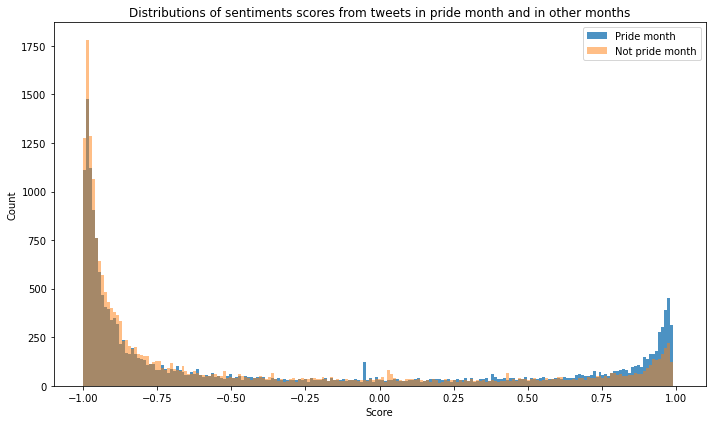

In [173]:
fig = plt.figure(1, [10, 6])
bins = np.linspace(-1, 1, 200)
plt.hist(pride_scores, bins, alpha=0.8, label='Pride month')
plt.hist(no_pride_scores, bins, alpha=0.5, label='Not pride month')
plt.legend(loc='upper right')
plt.title('Distributions of sentiments scores from tweets in pride month and in other months')
plt.xlabel('Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### Sentinemnt analysis discussion
To show that there is a significant difference we would have wanted to show that the data originated from different distributions. That is, the average of one group is found out of a confidence interval of at least 90% of the other group. It looks like we are not able to prove this. We are then not able to refute the null hypothesis that both groups come from the same distribution. 

Not only are the distributions inseparable, but they very much look alike. I think the cause for the similarity in the distributions derives from the fact that the analyzer, as said before, has the tendency to score the tweets very high or very low. That is why we can see something that looks like bimodality, for the two datasets. 

In absolute, the results were having a bad opinion, however I think that could be explained by other reasons but hatred. I think that the lgbt community still struggles for rights, equality and respect all over the world. There are a lot of political activities and manifestations for supporting the community, and many politicians and publicists post tweets as a protest. When analysing tweets that are part of a protest, the detected sentiment will very likely be bad, since the use of extreme words that are used. A great example for that is one of the tweets we saw earlier in the analysis. Observing the tweet by Sarah Silverman, it is clearly a pro-lgbt post. However in sentiment analysis, as it currently works, it is very likely that this post will be labeled by the analyser as a very bad opinion, because it reflects anger. We know from the context that it is not true. I think that is the main reason why we get bad opinions. I tend to believe that much of the negative tweets are detected as negative because of the lack of context consideration the analyzer is characterized with. 

We can notice the difference in the edges, on each of the two modals. There are more negative tweets in regular times than in pride month (we see that the count of the orange is higher). On the other side, in pride time there are much more positive tweets. The explanation for that might be that in "regular times'', having the lgbt fighting every day, then it is just natural that we get in normal times a lot of negative sentiment, because of the same reason I explained before. On the other hand, pride month is time to not only protest, but a lot of - celebrate and be proud. That explains why in pride month we have much more optimistic/positive tweets. 

Given the explanation I suggested for the result, which contains a relatively large number of negative sentiment tweets, it is possible that performing sentiment analysis is not very representative. Maybe feelings could be divided, and use a model to detect tone of protest. This could be complex, since both sides (pro-lgbt and anti lgbt), will be probably detected as protesting. We will still need to distill which size the protest is appost/support. Another possibility: instead of detecting positive and negative opinions, we can use another version of roberta, now with a task of 'hate' instead of 'sentiment analysis'. In that case, we might encounter the same problem where a protest post might be interpreted as hate, but it might be worth the try. The documentation of the model is in https://huggingface.co/cardiffnlp/twitter-roberta-base-hate. For consistency, again here I normalize the values to the range -1 to 1 while 1 is NO-HATE and -1 is HATE (so we are correlated the positivity and negativity of the sentiment analysis).

In [7]:
def hate_analysis(my_tweets):
    start_time = time.time()
    roberta = Analyzer(task='hate')
    my_tweets.rewind()
    counter = 0
    for t in my_tweets: 
        counter += 1
        text = t.get('content')
        if text:
            text = handler.clean_tweet(text)
            roberta.get_sentiment(text)
        if(counter%20000 == 0):
            print('------Time: ' + str(time.time()-start_time) + '; Counter = ' + str(counter) + '--------')       
            break
    mean_score = np.mean(roberta.scores)
    print("Average sentiment detected " + str(mean_score))
    return roberta.scores, time.time() - start_time

In [9]:
#HATE DETECTION OF ENGLISH TWEETS FROM PRIDE MONTH 
current_tweets = collection.find({'$and': 
                            [{'pride_month': True},
                           {'lang': 'en'}]}, {'content':1})
pride_hate, time_elapsed = hate_analysis(current_tweets)
#save the scores to files for backup
pride_hate_df = pd.DataFrame(pride_hate)
pride_hate_df.to_csv('pride_hate.csv')

------Time: 1838.6642711162567; Counter = 20000--------
Average sentiment detected 0.9058952365361154


In [10]:
#HATE DECTION OF ENGLISH TWEETS FROM OTHER MONTHS 
current_tweets = collection.find({'$and': 
                            [{'pride_month': False},
                           {'lang': 'en'}]}, {'content':1})
no_pride_hate, time_elapsed = hate_analysis(current_tweets)
#save the scores to files for backup
no_pride_hate_df = pd.DataFrame(no_pride_hate)
no_pride_hate_df.to_csv('no_pride_hate.csv')

------Time: 1839.5393373966217; Counter = 20000--------
Average sentiment detected 0.8977059413015842


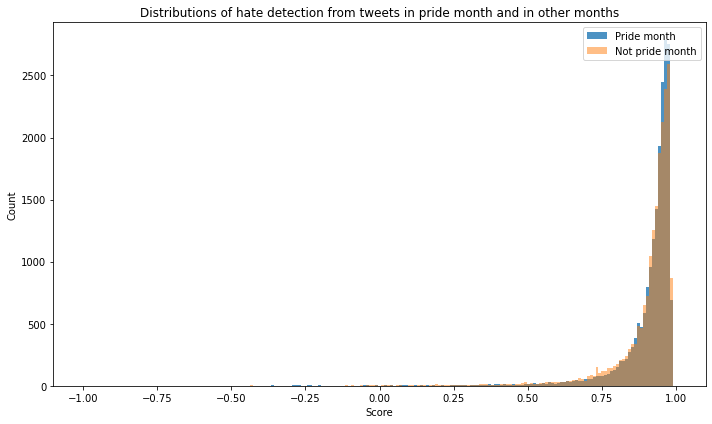

In [11]:
fig = plt.figure(1, [10, 6])
bins = np.linspace(-1, 1, 200)
plt.hist(pride_hate, bins, alpha=0.8, label='Pride month')
plt.hist(no_pride_hate, bins, alpha=0.5, label='Not pride month')
plt.legend(loc='upper right')
plt.title('Distributions of hate detection from tweets in pride month and in other months')
plt.xlabel('Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [12]:
current_tweets.close()

In [81]:
std_hate_pride_month = np.std(pride_hate)
std_hate_no_pride_month = np.std(no_pride_hate)
print('---Pride month hate std is ' + str(std_hate_pride_month) + ' while in other months std is ' 
      + str(std_hate_no_pride_month))

---Pride month hate std is 0.12548848081662156 while in other months std is 0.12981154125443578


Analysing the same tweets that were analyzed by the sentiment analyzer, we can now see that most of them (almost all of them) are not hateful. That reflects more my initial thought that most of the tweets will be pro lgbt and not the opposite. The distributions look again very alike. For the non-pride-month time the data look a **bit** more dispersed, while the pick at levels close to 1 is a bit higher in pride month. That also makes sense, since most of the lgbt referred tweets in pride time are expected to be positive - not-hate. 
 
Again, it is not possible to differentiate between the distribution but at least we learn that the general essence of those tweets is not hate. The fact that it is close to 1 not-hate, pinpoints it is probably a positive opinion, since it leaves no place to misinterpretation. 

## Conclusions:
We have seen many approaches to analyse the tweets, both in a more statistical way on its characteristics, such as hashtags, language etc, and also in the content aspect with sentiment analysis. The original data contained 400,000 tweets, half posted in pride month and the others in other times of the same year 2019. 

We used pymongo, no-Sql, and iterated either with cursors of mongo or converting the results of the query to a list, when it was helpful. 

First we saw the distribution of the languages among the tweets, and it was mostly English as expected. As for countries distribution we visualized the most common ones, while US has the highest number of tweets. Then we have tried to characterize which of the tweets are originals or were posted as a response or quote to another one. After that we looked at the most popular tweets from the dataset. We have, in addition observed the most popular hashtags in time of pride month and out of it. 

The other part of the work was to try to detect a trend in the content of tweets in pride month and in other times. We tested the sentiment detected in 40,000 lgbt-related tweets, half of them were posted in pride month (2019) and the other half from other months of the same year. Although I had more data (10 times the size) I was not able to exploit it fully for the purpose of sentiment analysis. 

We saw that it was impossible to show significance in the differences between the tweets in pride month compared to other times. We can not say that there exists a trend there. 

We could have made this research more complete if we had collected all of the data in that  period of time that is related to several terms in the scrape time and not only *'lgbt'*. Not only that, but also we were not able to process all the data we had collected. 

It is possible that the normalization to the range of -1,1 given the results of roberta is not sufficiently informative, or not reflecting the whole truth adequately. Maybe further research can be done while taking into consideration the 3 probabilities of roberta (or maybe 2 of them can be enough). 


The bottom line is that we can not say that there is a trend of positivity or negativity during pride month in comparison to other periods of the year. Taking into consideration the discussion in the Sentiment Analysis section, it is possible that it is too tricky to resolve the question with the means I used, because of the difficulty to differentiate between protest/anger or hatred, and enthusiastic support of the sides. In absolute characterization however, basing on the hate-detection, we could see that most of the tweets were not hateful. That can lead us to carefully conclude that that general approach does not go against lgbt, but if anything - the other way around. 

### Citing

Citing sentiment analyzer:
>@inproceedings{rosenthal2017semeval,
  title={SemEval-2017 task 4: Sentiment analysis in Twitter},
  author={Rosenthal, Sara and Farra, Noura and Nakov, Preslav},
  booktitle={Proceedings of the 11th international workshop on semantic evaluation (SemEval-2017)},
  pages={502--518},
  year={2017}
}

Citing hate speech detection:
>@inproceedings{basile-etal-2019-semeval,
    title = "{S}em{E}val-2019 Task 5: Multilingual Detection of Hate Speech Against Immigrants and Women in {T}witter",
    author = "Basile, Valerio  and Bosco, Cristina  and Fersini, Elisabetta  and Nozza, Debora and Patti, Viviana and
      Rangel Pardo, Francisco Manuel  and Rosso, Paolo  and Sanguinetti, Manuela",
    booktitle = "Proceedings of the 13th International Workshop on Semantic Evaluation",
    year = "2019",
    address = "Minneapolis, Minnesota, USA",
    publisher = "Association for Computational Linguistics",
    url = "https://www.aclweb.org/anthology/S19-2007",
    doi = "10.18653/v1/S19-2007",
    pages = "54--63"
}